In [22]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [11]:
ind="stashcp-2016.6"

myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*a2gb*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1466622721000,
                  "lte": 1466674003000,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*a2gb*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1466622721000,
                  "lte": 1466674003000,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

# Create total results list from es scroll

In [12]:
page= es.search(index=ind, body=myquery1, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

1640


# Create dataframe from results

In [13]:
df = pd.DataFrame(Res)

del df['destination_space']
del df['xrdcp_version']
del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(df.head(2))
print(list(df.columns.values))

  download_time                         filename                        host  \
0        195689  user/taburaad/public/a2gb_1.tar  root://data.ci-connect.net   
1        213298  user/taburaad/public/a2gb_1.tar  root://data.ci-connect.net   

   sitename         status      timestamp          begin  
0  SU-OG-CE  Trunk Success  1466622721000  1466622525311  
1  SU-OG-CE  Trunk Success  1466622996000  1466622782702  
['download_time', 'filename', 'host', 'sitename', 'status', 'timestamp', 'begin']


In [14]:
df_UCSDT2=pd.DataFrame(columns=['download_time','filename','host','sitename','status','timestamp'])
for i in range(scroll_size):
    if df.iloc[i,3]=='UCSDT2-C':
        df_UCSDT2=df_UCSDT2.append(df.iloc[[i]])
        
df_UCSDT2=df_UCSDT2.sort_values(by=['timestamp'])
df_UCSDT2['try']=0
f=0
s=0
i=0
length=df_UCSDT2.shape[0]
#print(df_UCSDT2.head(10))    
while i<200:
    df_UCSDT2.iloc[i,6]=1
    df_UCSDT2.iloc[i+1,6]=2
    f+=int(df_UCSDT2.iloc[i,0])
    s+=int(df_UCSDT2.iloc[i+1,0])
    i=i+2
    
#second / first try = speed-up
UCSDT2_speedup=(s/f)
print(UCSDT2_speedup)

1.0000002012311404


In [15]:
def speed_up(sitename):
    columns=list(df.columns.values)
    df_site=pd.DataFrame(columns=columns)
    for i in range(scroll_size):
        if df['sitename'][i]==sitename:
            df_site=df_site.append(df.iloc[[i]])
            
    df_site=df_site.sort_values(by=['timestamp'])
    df_site['try']=0
    #print (df_site['host'].iloc[1])
    f=0
    s=0
    i=0
    length=df_site.shape[0]
    #print (length)
    if (length%2==1):
        df_site=df_site[:length-1]
    length=df_site.shape[0]
    host=df_site['host'].iloc[1]
    #print (length)
    #print(df_site.head(100))
    while i<length:
        df_site['try'][i]=1
        df_site['try'][i+1]=2
        f+=int(df_site['download_time'].iloc[i])
        s+=int(df_site['download_time'].iloc[i+1])
        i+=2

    #second / first try = speed-up
    speedup=(s/f)
    avg1=(f/length)/1000
    avg2=(s/length)/1000
    print("- speed up: %.2f, avg first try: %.2f sec, avg second try: %.2f sec using host %s" % (speedup, avg1, avg2, host))

speed_up('UFlorida-HPC')

- speed up: 0.99, avg first try: 40.15 sec, avg second try: 39.76 sec using host root://data.ci-connect.net


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
print("UCSDT2-C:")
speed_up('UCSDT2-C')
print("BNL_ATLAS_1:")
speed_up('BNL_ATLAS_1')
print("UFlorida-HPC:")
speed_up('UFlorida-HPC')
print("UNL (red-gateway2):")
speed_up('red-gateway2')
print("MWT2_CE_UIUC:")
speed_up('MWT2_CE_UIUC')
print("UNC: (Sandhills-CE1):")
speed_up('Sandhills-CE1')
print("SU-OG-CE:")
speed_up('SU-OG-CE')

UCSDT2-C:


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


- speed up: 0.08, avg first try: 146.30 sec, avg second try: 11.53 sec using host root://xrd-cache-1.t2.ucsd.edu
BNL_ATLAS_1:
- speed up: 0.95, avg first try: 55.16 sec, avg second try: 52.68 sec using host root://data.ci-connect.net
UFlorida-HPC:
- speed up: 0.99, avg first try: 40.15 sec, avg second try: 39.76 sec using host root://data.ci-connect.net
UNL (red-gateway2):
- speed up: 0.24, avg first try: 42.18 sec, avg second try: 10.27 sec using host root://hcc-stash.unl.edu
MWT2_CE_UIUC:
- speed up: 1.30, avg first try: 23.81 sec, avg second try: 30.99 sec using host root://data.ci-connect.net
UNC: (Sandhills-CE1):
- speed up: 0.38, avg first try: 23.83 sec, avg second try: 8.99 sec using host root://hcc-stash.unl.edu
SU-OG-CE:
- speed up: 0.99, avg first try: 102.83 sec, avg second try: 101.83 sec using host root://data.ci-connect.net


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
def plot_concurrent_jobs(host):
    columns=list(df.columns.values)
    df_site=pd.DataFrame(columns=columns)
    for i in range(scroll_size):
        if df['host'][i]==host:
            df_site=df_site.append(df.iloc[[i]])
    length=df_site.shape[0]
    
    minX=int(df_site.ix[df_site['begin'].idxmin()]['begin'])
    maxX=int(df_site.ix[df_site['timestamp'].idxmax()]['timestamp'])
    #minX=round(int(df_site.ix[df_site['begin'].idxmin()]['begin'])/(1000*60))
    #maxX=round(int(df_site.ix[df_site['timestamp'].idxmax()]['timestamp'])/(1000*60))
    #minX=int(minX/(1000*60))
    #maxX=int(maxX/(1000*60))
    
    print (minX)
    print (maxX)
    print (maxX-minX)
    n=1000*30
    print(n)
    x=np.arange(minX, maxX+1, n)
    #print (x)
    nJobs=[0] * len(x)
    #print(df_site.head(2))
    print (length)
    #print (nJobs)
    print(len(nJobs))
    for i in range(len(x)): #len(x)
        for j in range(length): #length
            #print (int(df_site['begin'].iloc[j]))
            #print (int(df_site['timestamp'].iloc[j]))
            #print (x[i])
            if np.less(int(df_site['begin'].iloc[j]),x[i]) and np.less(x[i],int(df_site['timestamp'].iloc[j])):  
                nJobs[i]=nJobs[i]+1
                #print('tru')
            #print('---')
    return nJobs,x
    
    
nJobs,x=plot_concurrent_jobs('root://data.ci-connect.net')


1466622525311
1466674003000
51477689
30000
768
1716


[ 1  4  7 10]
[7, 8, 8, 8, 18, 24, 25, 22, 31, 32, 32, 32, 34, 34, 34, 32, 33, 33, 35, 30, 34, 32, 33, 30, 35, 39, 32, 28, 33, 31, 25, 25, 25, 23, 23, 24, 22, 26, 24, 23, 22, 23, 23, 23, 24, 25, 23, 23, 24, 26, 25, 25, 24, 23, 24, 26, 26, 24, 24, 23, 25, 21, 24, 14, 16, 13, 15, 14, 14, 16, 16, 14, 11, 14, 14, 15, 13, 15, 13, 16, 15, 12, 15, 10, 14, 14, 12, 13, 14, 12, 12, 14, 14, 14, 11, 13, 14, 14, 15, 14, 16, 14, 13, 14, 12, 14, 14, 14, 14, 12, 13, 14, 13, 13, 14, 16, 12, 7, 8, 8, 8, 8, 6, 8, 8, 8, 7, 7, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 8, 7, 10, 8, 8, 9, 9, 8, 10, 8, 8, 10, 8, 8, 10, 8, 7, 8, 8, 8, 8, 8, 8, 0]


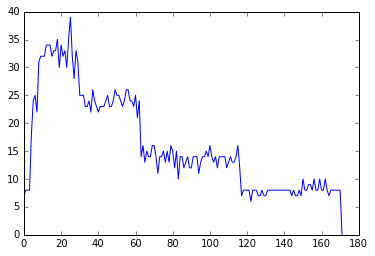

In [19]:
#print (np.less(1,2))
#print (np.less(df['begin'].iloc[1],x[1]))
#print (df['begin'].iloc[1])

y=np.arange(1, 11, 3)
print (y)

#plt.plot(nJobs)
#plt.ylabel('Count')
#plt.show()
x2=np.arange(1466622525311, 1466674003001, 30000*10)
nJobs2=[0]*len(x2)
p=0
count=0
cSum=0
for i in range(len(x)):
        #print (p)
       # print (count)
        cSum=cSum+nJobs[i]
        count=count+1
        #print (cSum)
        if count==10:
            nJobs2[p]=cSum
            p=p+1
            count=0
            cSum=0
print (nJobs2)

plt.plot(nJobs2)
#plt.ylabel('Count')
plt.show()


In [37]:
columns=list(df.columns.values)
df1=pd.DataFrame(columns=columns)
for i in range(scroll_size):
    if df['host'][i]=='root://data.ci-connect.net':
        df1=df1.append(df.iloc[[i]])
print(df1.head(2))
length=df1.shape[0]

for i in range(10):
    begin=int(df1['begin'].iloc[i])//1000
    end=int(df1['timestamp'].iloc[i])//1000
    print(datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S'))
    print(datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S'))

open1 = pd.concat([pd.Series(1, df1.begin),  # created add 1
                           pd.Series(-1, df1.timestamp)  # closed substract 1
                           ]).resample('30Min', how='sum').cumsum()

  download_time                         filename                        host  \
0        195689  user/taburaad/public/a2gb_1.tar  root://data.ci-connect.net   
1        213298  user/taburaad/public/a2gb_1.tar  root://data.ci-connect.net   

   sitename         status      timestamp         begin  
0  SU-OG-CE  Trunk Success  1466622721000  1.466623e+12  
1  SU-OG-CE  Trunk Success  1466622996000  1.466623e+12  
2016-06-22 14:08:45
2016-06-22 14:12:01
2016-06-22 14:13:02
2016-06-22 14:16:36
2016-06-22 14:17:38
2016-06-22 14:20:32
2016-06-22 14:21:34
2016-06-22 14:24:20
2016-06-22 14:29:12
2016-06-22 14:32:18
2016-06-22 14:32:28
2016-06-22 14:33:08
2016-06-22 14:31:53
2016-06-22 14:33:46
2016-06-22 14:33:09
2016-06-22 14:33:48
2016-06-22 14:33:48
2016-06-22 14:34:29
2016-06-22 14:41:39
2016-06-22 14:42:33
2016-06-22 14:08:45
